In [100]:
import json
from collections import defaultdict
from dataclasses import dataclass
import numpy as np

import seaborn as sns

analyses_output_filename = 'output_apo_holo_2021-10-21T15:16:45.148250.json'
domain_info_filename = 'output_domains_info2021-10-21T15:16:45.148250.json'

import pandas as pd

with open(analyses_output_filename) as f:
    analyses_json = json.load(f)

analyses_output = defaultdict(list)

for obj in analyses_json:
    def tuple_it(l):
        if isinstance(l, list):
            return tuple(map(tuple_it, l))
        else:
            return l

    obj['args'] = tuple_it(obj['args'])  # json converted all my tuples to lists... won't work with hashing for joins..
    analyses_output[obj['level_tag']].append(obj)

analyses_dfs = {}
# convert analyses outputs to DataFrames
for k in analyses_output:
    analyses_dfs[k] = pd.DataFrame(analyses_output[k])

# analyses_output = pd.read_json(analyses_output_filename)
domain_info = pd.read_json(domain_info_filename)
domain_info['chain'] = list(zip(domain_info.pdb_code, domain_info.chain_id))


def unfold_tuple_to_columns(series_or_df_with_tuple_column, new_column_names, column_name=None):
    """ Unfolds a column `column_name` with tuples and adds the unfolded series as new columns.
    Original column of tuples unchanged. """
    to_unfold = series_or_df_with_tuple_column

    if isinstance(series_or_df_with_tuple_column, pd.DataFrame):
        assert column_name is not None
        to_unfold = series_or_df_with_tuple_column[column_name]

    unfolded_cols = to_unfold.apply(pd.Series)
    unfolded_cols.columns = new_column_names
    return pd.concat([series_or_df_with_tuple_column, unfolded_cols], axis=1)




# with open(domain_info_filename) as f:
#     domain_info = json.load(f)

get apo-holo pairs
jinak nevim, co patri k sobe
treba z toho analyses_output,

In [92]:
# indices = analyses_output['analysis_name'] == 'GetRMSD'
# indices = indices & (pd.Series([len(args) for args in analyses_output['args']]) == 2)
#
# hah = analyses_output[indices]

Divide chains in multi-domain and single domain groups

In [93]:
a_h_pairs = analyses_dfs['chain2chain']['args'].drop_duplicates()
# unfold the tuple of chains into two columns
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_chain','holo_chain'])


In [94]:
@dataclass
class Chain:
    pdb_code: str
    chain_id: str

domain_info = domain_info.rename(columns={'result': 'domain_count'})
total = domain_info[domain_info['type'] == 'total_domains_found']
analyzed = domain_info[domain_info['type'] == 'analyzed_domain_count']

print(total[total['domain_count'] == 1]['domain_count'].count())
print(total[total['domain_count'] > 1]['domain_count'].count())

612
374


In [95]:
# do single dám zatim i ty, co maj total domain víc
# ale do bakalarky to udelam i s porovnanim, kdyz maj jen 1 (kolik jich je - pouze 2 chainy, ktery maj vic total
# domains..)

multi_domain_chains = analyzed[analyzed['domain_count'] > 1]['chain']
single_domain_chains = analyzed[analyzed['domain_count'] == 1]['chain']

print(single_domain_chains.count())
print(multi_domain_chains.count())

print(len(multi_domain_chains))
# print(domain_count)
print(len(single_domain_chains))

# label single, multi domain pairs
a_h_pairs = a_h_pairs.merge(analyzed[['chain', 'domain_count']], left_on='apo_chain', right_on='chain')
#
# multi_domain_pairs = a_h_pairs.merge(multi_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                   'holo_chain']]
# single_domain_pairs = a_h_pairs.merge(single_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                                                                                                                    'holo_chain']]
# chci col a-h tuplů, a col single/multi

# todo
# describe pairs - count, min, max length (don't have that in saved metadata)
# filter two-domain arrangements (if of both apo and holo > 200 A^2)

610
376
376
610


Paper:
> 521 representative ligand-bound/
ligand-free pairs with lengths varying from 50 to 1392
residues was compiled. This results in 328 single-domain
proteins, 193 multiple-domain proteins, 487 individual
protein domains, and 311 two-domain arrangements.

Therefore as "individual domains" they mean only those from multi-domain proteins.

A-H Secondary structure identity in single/multi domain proteins (proteins myslej páry)
- join ss analysis with domain counts (decide what if # total domains different in pair or != 1)
histogram with bins for SS identity (2%)

<AxesSubplot:xlabel='result', ylabel='Probability'>

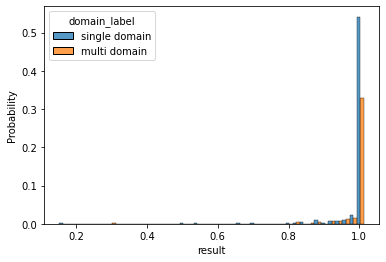

In [96]:
# jenze ted je zas to zabaleny...
df = analyses_dfs['chain2chain']
df = df[df.analysis_name == 'CompareSecondaryStructure']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'

sns.histplot(df, x='result', stat='probability', hue='domain_label', multiple='dodge', binwidth=0.02)


A-H RMSD (single, multi, individual domains)
- individual domains je vlastni analyza, ale podvybrat jen multi-domain

<AxesSubplot:xlabel='result', ylabel='Probability'>

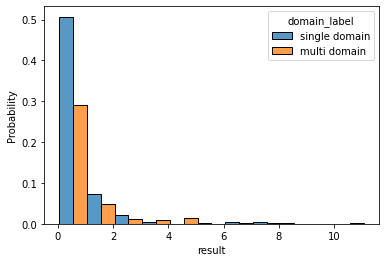

In [97]:
df = analyses_dfs['chain2chain']
df = df[df.analysis_name == 'GetRMSD']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'

sns.histplot(df, x='result', stat='probability', hue='domain_label', multiple='dodge', binwidth=1)


H-H RMSD - to zatim nemám

## Domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 108)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

- v podstate concat tech dvou analyz

<AxesSubplot:xlabel='hinge_angle', ylabel='result_x'>

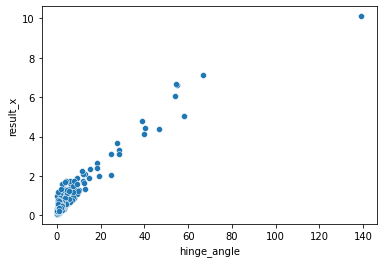

In [111]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_dfs['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD']
hinge_df = df[df.analysis_name == 'GetHingeAngle']
hinge_df = unfold_tuple_to_columns(hinge_df, ['hinge_angle', 'translation_in_axis'], 'result')
# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

df = rmsd_df.merge(hinge_df, left_on='args', right_on='args')

sns.scatterplot(data=df, x='hinge_angle', y='result_x')

# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají translation_in_axis, třeba
# větší než hinge
# podle částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Mozna, ze ta moje
# druha kategorie bude krásně na diagonále true shear bude od ní. Kdoví. Ale taky se nemusí měnit iface v některých
# konfiguracích, i když dojde k translation



2DA ligand-bound vs ligand-free buried interface
- tady vubec potrebuju ty arrangements, ktery treba nemam?
- ty mam bud u 2DA RMSD nebo 2DA angle, je to jedno, oboji vzdy funguje
- join s iface dle paru v jedny str. na apo field a pak druhy na holo

v obou analýzách nejsou a-h-páry, musim to fetchnout pro kazdy z nich
- vlastne pro kazdy 2DA, který nemám expl. nikde, vyuziju tedy RMSD třeba

<AxesSubplot:xlabel='holo_interface', ylabel='apo_interface'>

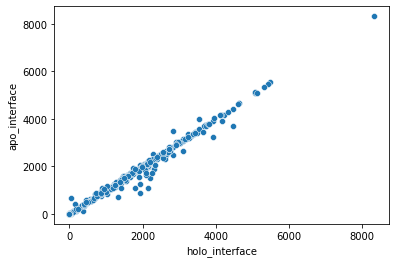

In [105]:
df = analyses_dfs['chain2DA2chain2DA']
two_domain_arrangements = df[df.analysis_name == 'GetRMSD']['args']
two_domain_arrangements = unfold_tuple_to_columns(two_domain_arrangements, ['apo_domains', 'holo_domains'])

df = analyses_dfs['2DA']
interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea']

df = two_domain_arrangements.merge(interface_area, left_on='apo_domains', right_on='args')
df = df.rename(columns={'result': 'apo_interface'})
df = df.merge(interface_area, left_on='holo_domains', right_on='args')
df = df.rename(columns={'result': 'holo_interface'})

sns.scatterplot(data=df, x='holo_interface', y='apo_interface')

2DA
prediktor large-scale motion type z apo interface buried

interface buried (apo) vs (bending)|(RMSD - opět 2DA-explicitně)
- scatter and histogram


<AxesSubplot:xlabel='apo_interface', ylabel='hinge_angle'>

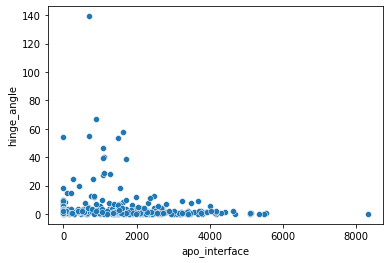

In [115]:
df = unfold_tuple_to_columns(hinge_df, ['apo_domains', 'holo_domains'], 'args')
df = df.merge(interface_area, left_on='apo_domains', right_on='args')
df = df.rename(columns={'result_y': 'apo_interface'})
sns.scatterplot(data=df, x='apo_interface', y='hinge_angle')

<AxesSubplot:xlabel='apo_interface', ylabel='rmsd'>

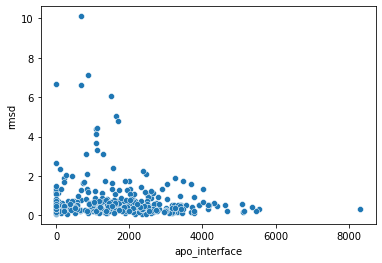

In [116]:
df = unfold_tuple_to_columns(rmsd_df, ['apo_domains', 'holo_domains'], 'args')
df = df.merge(interface_area, left_on='apo_domains', right_on='args')
df = df.rename(columns={'result_x': 'rmsd'})
df = df.rename(columns={'result_y': 'apo_interface'})
sns.scatterplot(data=df, x='apo_interface', y='rmsd')



table with selected 2DA

todo extract the pair codes and do a similar table (choosing from 2DA file, should be easy)

|apo_code|holo_code|2 domains id|a-interface| h-interface|bending[deg]| RMSD